# Judge, Jury, and Classifier: An Introduction to Trees

<img src="images/CourtBuilding.jpg"/>

Last week, in the Moneyball lecture, we discussed how regular season performance is not strongly correlated with winning the World Series in baseball. In this homework question, we'll use the same data to investigate how well we can predict the World Series winner at the beginning of the playoffs.

To begin, load the dataset baseball.csv into R using the read.csv function, and call the data frame "baseball". This is the same data file we used during the Moneyball lecture, and the data comes from Baseball-Reference.com.

As a reminder, this dataset contains data concerning a baseball team's performance in a given year. It has the following variables:

    Team: A code for the name of the team
    
    League: The Major League Baseball league the team belongs to, either AL (American League) or NL (National League)
    
    Year: The year of the corresponding record
    
    RS: The number of runs scored by the team in that year
    
    RA: The number of runs allowed by the team in that year
    
    W: The number of regular season wins by the team in that year
    
    OBP: The on-base percentage of the team in that year
    
    SLG: The slugging percentage of the team in that year
    
    BA: The batting average of the team in that year
    
    Playoffs: Whether the team made the playoffs in that year (1 for yes, 0 for no)
    
    RankSeason: Among the playoff teams in that year, the ranking of their regular season records (1 is best)
    
    RankPlayoffs: Among the playoff teams in that year, how well they fared in the playoffs. The team winning the World Series gets a RankPlayoffs of 1.
    
    G: The number of games a team played in that year
    
    OOBP: The team's opponents' on-base percentage in that year
    
    OSLG: The team's opponents' slugging percentage in that year

### Data

Cases from 1994 through 2001

In this period, same nine justices presided SCOTUS

    Breyer, Ginsburg, Kennedy, O’Connor, Rehnquist (Chief Justice), Scalia, Souter, Stevens, Thomas
    Rare data set - longest period of time with the same set of justices in over 180 years

We will focus on predicting Justice Stevens’ decisions

    Started out moderate, but became more liberal
    Self-proclaimed conservative

### Variables

    * Dependent Variable: Did Justice Stevens vote to reverse the lower court decision? 1 = reverse, 0 = affirm

    * Indepedent Variable: Properties of the case
                           Circuit court of origin
                           Issue area of case
                           Type of petitioner, type of respondent
                           Ideological direction of lower court decision
                           Whether petitioner argued that a law/practice was unconstitutional

### Logistic Regression for Justice Stevens

Some significant variables and their coefficients

    Case is from 2nd circuit court: +1.66
    Case is from 4th circuit court: +2.82
    Lower court decision is liberal: -1.22

This is complicated

    Difficult to understand which factors are important
    Difficult to quickly evaluate what prediction is for a new case

### Classification and Regression Trees

    Build a tree by splitting on variables
    To predict the outcome for an observation, follow the splits and at the end, predict the most frequent outcome
    Does not assume a linear model
    Interpret able

### Load and Exploration the Data

In [1]:
stevens = read.csv("data/stevens.csv")
head(stevens)

,Docket,Term,Circuit,Issue,Petitioner,Respondent,LowerCourt,Unconst,Reverse
,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>
1,93-1408,1994,2nd,EconomicActivity,BUSINESS,BUSINESS,liberal,0,1
2,93-1577,1994,9th,EconomicActivity,BUSINESS,BUSINESS,liberal,0,1
3,93-1612,1994,5th,EconomicActivity,BUSINESS,BUSINESS,liberal,0,1
4,94-623,1994,1st,EconomicActivity,BUSINESS,BUSINESS,conser,0,1
5,94-1175,1995,7th,JudicialPower,BUSINESS,BUSINESS,conser,0,1
6,95-129,1995,9th,EconomicActivity,BUSINESS,BUSINESS,conser,1,0


In [2]:
str(stevens)

'data.frame':	566 obs. of  9 variables:
 $ Docket    : Factor w/ 566 levels "00-1011","00-1045",..: 63 69 70 145 97 181 242 289 334 436 ...
 $ Term      : int  1994 1994 1994 1994 1995 1995 1996 1997 1997 1999 ...
 $ Circuit   : Factor w/ 13 levels "10th","11th",..: 4 11 7 3 9 11 13 11 12 2 ...
 $ Issue     : Factor w/ 11 levels "Attorneys","CivilRights",..: 5 5 5 5 9 5 5 5 5 3 ...
 $ Petitioner: Factor w/ 12 levels "AMERICAN.INDIAN",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Respondent: Factor w/ 12 levels "AMERICAN.INDIAN",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ LowerCourt: Factor w/ 2 levels "conser","liberal": 2 2 2 1 1 1 1 1 1 1 ...
 $ Unconst   : int  0 0 0 0 0 1 0 1 0 0 ...
 $ Reverse   : int  1 1 1 1 1 0 1 1 1 1 ...


In [3]:
summary(stevens)

     Docket         Term         Circuit                  Issue    
 00-1011:  1   Min.   :1994   9th    :122   CriminalProcedure:132  
 00-1045:  1   1st Qu.:1995   5th    : 53   JudicialPower    :102  
 00-1072:  1   Median :1997   11th   : 49   EconomicActivity : 98  
 00-1073:  1   Mean   :1997   7th    : 47   CivilRights      : 74  
 00-1089:  1   3rd Qu.:1999   4th    : 46   DueProcess       : 43  
 00-121 :  1   Max.   :2001   8th    : 44   FirstAmendment   : 39  
 (Other):560                  (Other):205   (Other)          : 78  
               Petitioner               Respondent    LowerCourt 
 OTHER              :175   OTHER             :177   conser :293  
 CRIMINAL.DEFENDENT : 89   BUSINESS          : 80   liberal:273  
 BUSINESS           : 79   US                : 69                
 STATE              : 48   CRIMINAL.DEFENDENT: 58                
 US                 : 48   STATE             : 56                
 GOVERNMENT.OFFICIAL: 38   EMPLOYEE          : 28           

## Split the data

Now before building models, we need to split our data into a training set and a testing set. We'll do this using the sample.split function, like we did last week for logistic regression.

In [4]:
#install.packages("caTools")
library(caTools)

In [5]:
set.seed(3000) # For all students have the same results

spl = sample.split(stevens$Reverse, SplitRatio = 0.7) 

Where the first argument needs to be our outcome variable, stevens$Reverse, and then the second argument is the SplitRatio, or the percentage of data that we want to put in the training set. In this case, we'll put 70\% of the data in the training set.

In [6]:
Train = subset(stevens, spl==TRUE)  #70%
Test = subset(stevens, spl==FALSE)  #30%

### Install rpart library

In [7]:
#install.packages("rpart")
library(rpart)

#install.packages("rpart.plot")
library(rpart.plot)

### CART model

We'll call our model StevensTree, and we'll use the *rpart* function, where the first argument is the same as if we were building a linear or logistic regression model.

We give our dependent variable, in our case, *Reverse*, followed by a tilde sign, and then the independent variables separated by plus signs. So Circuit + Issue + Petitioner + Respondent + LowerCourt + Unconst. We also need to give our data set that should be used to build our model, which in our case is *Train*.

Now we'll give two additional arguments here. The first one is method = "class". This tells rpart to build a classification tree, instead of a regression tree. You'll see how we can create regression trees in recitation. 

The last argument we'll give is *minbucket* = 25. This limits the tree so that it doesn't overfit to our training set.

In [8]:
StevensTree = rpart(Reverse ~ Circuit + Issue + Petitioner + Respondent + LowerCourt + Unconst, data = Train, 
                    method="class", minbucket=25)

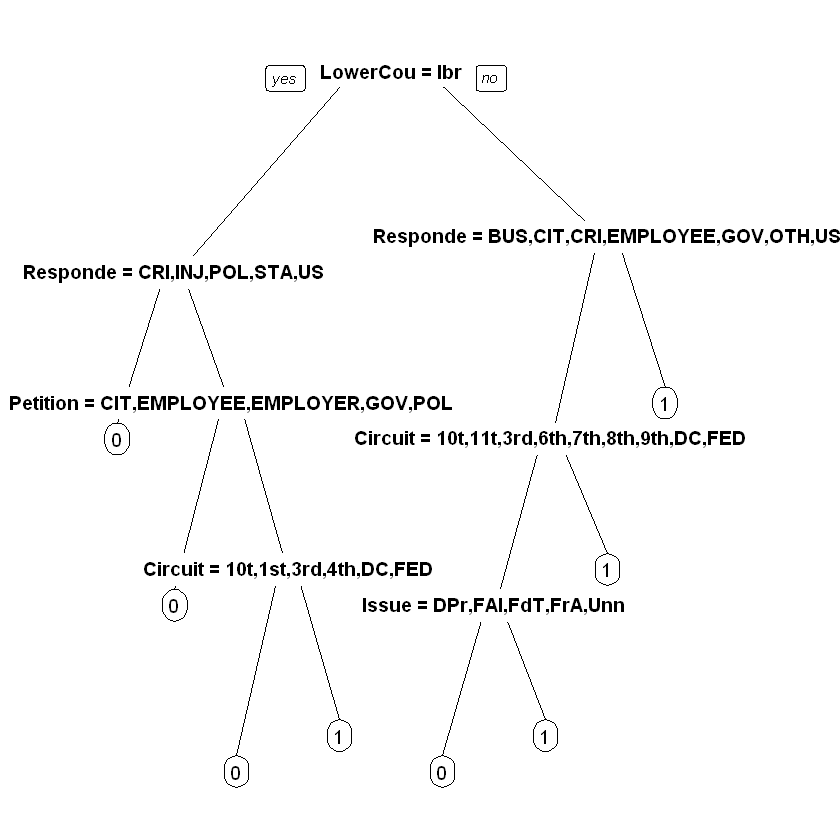

In [9]:
prp(StevensTree) # Plot the Tree

### Make predictions

In [10]:
PredictCART = predict(StevensTree, newdata = Test, type = "class")

We need to give the argument "class" when making predictions for our CART model if we want the majority class predictions. This is like using a threshold of 0.5.

In [11]:
# Confusion Matrix
z = table(Test$Reverse, PredictCART)
z

   PredictCART
     0  1
  0 41 36
  1 22 71

The rows are labeled with the actual outcome, and the columns are labeled with the predicted outcome.

                  Predict 0       Predict 1
    Actual 0    True Negative   False Positive
    Actual 1    False Negative  True Positive

    z = [1][3]
        [2][4]

In [12]:
# Calculate accuracy                        # (TN+TP)/(TN+FN+TP+FP)
accur <- (z[1]+z[4])/(z[1]+z[2]+z[3]+z[4])  # Another way: sum(diag(z))/sum(z)
paste("Accuracy CART: ", round(accur,digits=4))

[1] "Accuracy CART:  0.6588"

So the accuracy of our CART model is 0.659. If you were to build a logistic regression model, you would get an accuracy of 0.665 and a baseline model that always predicts Reverse, the most common outcome, has an accuracy of 0.547. So our CART model significantly beats the baseline and is competitive with logistic regression.

It's also much more interpretable than a logistic regression model would be.

###  Receiver Operator Characteristic (ROC) curve

In [13]:
#install.packages("ROCR")
library(ROCR)

In [14]:
PredictROC = predict(StevensTree, newdata = Test)
head(PredictROC)
nrow(PredictROC)

,0,1
1,0.3035714,0.6964286
3,0.3035714,0.6964286
4,0.4000000,0.6000000
6,0.4000000,0.6000000
8,0.4000000,0.6000000
21,0.3035714,0.6964286


[1] 170

For each observation in the test set, it gives two numbers which can be thought of as the probability of outcome 0 and the probability of outcome 1.

More concretely, each test set observation is classified into a subset, or bucket, of our CART tree. These numbers give the percentage of training set data in that subset with outcome 0 and the percentage of data in the training set in that subset with outcome 1.

**We'll use the second column as our probabilities to generate an ROC curve.** So just like we did last week for logistic regression, we'll start by using the prediction function. We'll call the output pred, and then use prediction, where the first argument is the second column of PredictROC, which we can access with square brackets, and the second argument is the true outcome values, Test\\$Reverse.

In [15]:
pred = prediction(PredictROC[,2], Test$Reverse)

Now we need to use the performance function, where the first argument is the outcome of the prediction function, and then the next two arguments are true positive rate and false positive rate, what we want on the x and y-axes of our ROC curve.

In [16]:
perf = performance(pred, "tpr", "fpr")

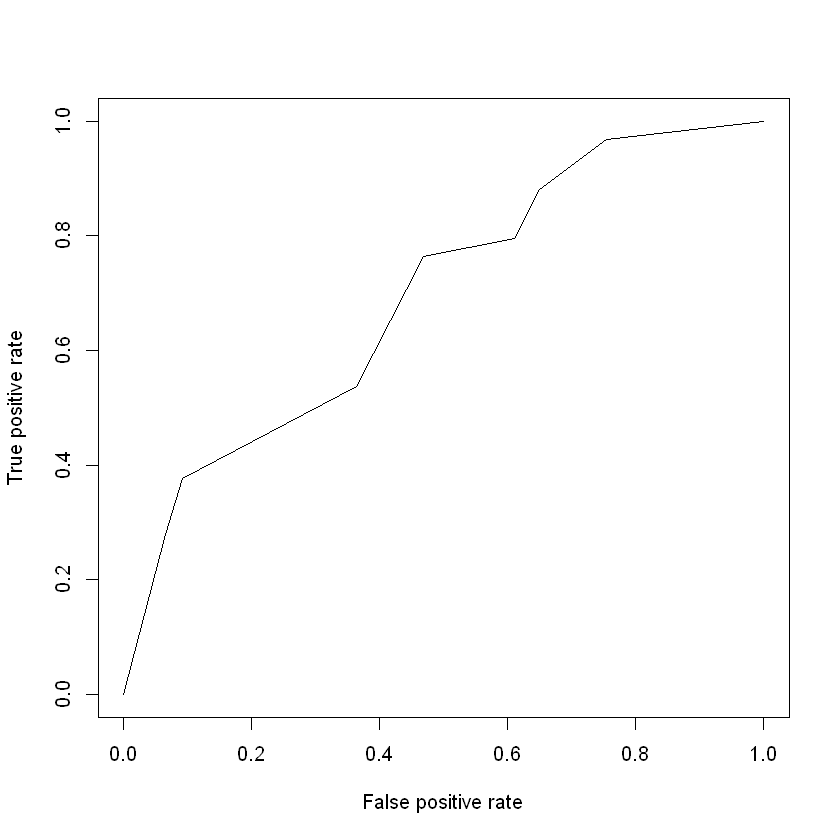

In [17]:
plot(perf)

Another method that is similar to CART is called **Random Forests**. This method was designed to improve the prediction accuracy of CART and works by building a large number of CART trees. Unfortunately, this makes the method less interpretable than CART, so often you need to decide if you value the interpretability or the increase in accuracy more.

To make a prediction for a new observation, each tree in the forest votes on the outcome and we pick the outcome that receives
the majority of the votes.

### Install RandomForest package

In [18]:
#install.packages("randomForest")
library(randomForest)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.



So how does random forests build many CART trees? We can't just run CART multiple times because it would create the same tree every time. To prevent this, random forests only allows each tree to split on a random subset of the available independent variables, and each tree is built from what we call a bagged or bootstrapped sample of the data. This just means that the data used as the training data for each tree is selected randomly with replacement.

In [19]:
# Build random forest model
StevensForest = randomForest(Reverse ~ Circuit + Issue + Petitioner + Respondent + LowerCourt + Unconst, 
                             data = Train, ntree=200, nodesize=25 )

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


Just like CART, random forests has some parameter values that need to be selected. The first is the minimum number of observations in a subset, or the minbucket parameter from CART. When we create a random forest in R, this will be called nodesize. A smaller value of nodesize, which leads to bigger trees, may take longer in R. Random forests is much more computationally intensive than CART.

The second parameter is the number of trees to build, which is called ntree in R. This should not be set too small, but the larger it is the longer it will take. A couple hundred trees is typically plenty. A nice thing about random forests is that it's not as sensitive to the parameter values as CART is.

**The RandomForest function does not have a method argument.** So when we want to do a classification problem, we need to make sure outcome is a factor. Let's convert the variable Reverse to a factor variable in both our training and our testing sets.

In [20]:
# Convert outcome to factor
Train$Reverse = as.factor(Train$Reverse)
Test$Reverse = as.factor(Test$Reverse)

In [21]:
str(Train)

'data.frame':	396 obs. of  9 variables:
 $ Docket    : Factor w/ 566 levels "00-1011","00-1045",..: 69 97 242 334 436 505 508 527 155 426 ...
 $ Term      : int  1994 1995 1996 1997 1999 1999 2000 2000 1994 1999 ...
 $ Circuit   : Factor w/ 13 levels "10th","11th",..: 11 9 13 12 2 4 8 11 9 5 ...
 $ Issue     : Factor w/ 11 levels "Attorneys","CivilRights",..: 5 9 5 5 3 5 5 4 5 6 ...
 $ Petitioner: Factor w/ 12 levels "AMERICAN.INDIAN",..: 2 2 2 2 2 2 2 2 3 3 ...
 $ Respondent: Factor w/ 12 levels "AMERICAN.INDIAN",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ LowerCourt: Factor w/ 2 levels "conser","liberal": 2 1 1 1 1 1 1 2 2 2 ...
 $ Unconst   : int  0 0 0 0 0 0 1 1 0 0 ...
 $ Reverse   : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 1 1 ...


In [22]:
str(Test)

'data.frame':	170 obs. of  9 variables:
 $ Docket    : Factor w/ 566 levels "00-1011","00-1045",..: 63 70 145 181 289 366 71 110 169 190 ...
 $ Term      : int  1994 1994 1994 1995 1997 1998 1994 1995 1996 1996 ...
 $ Circuit   : Factor w/ 13 levels "10th","11th",..: 4 7 3 11 11 7 1 1 4 12 ...
 $ Issue     : Factor w/ 11 levels "Attorneys","CivilRights",..: 5 5 5 5 5 9 8 5 8 9 ...
 $ Petitioner: Factor w/ 12 levels "AMERICAN.INDIAN",..: 2 2 2 2 2 8 9 9 9 9 ...
 $ Respondent: Factor w/ 12 levels "AMERICAN.INDIAN",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ LowerCourt: Factor w/ 2 levels "conser","liberal": 2 2 1 1 1 2 2 2 2 2 ...
 $ Unconst   : int  0 0 0 1 1 1 0 0 1 0 ...
 $ Reverse   : Factor w/ 2 levels "0","1": 2 2 2 1 2 1 1 1 1 2 ...


In [23]:
# Try again
StevensForest = randomForest(Reverse ~ Circuit + Issue + Petitioner + Respondent + LowerCourt + Unconst, 
                             data = Train, ntree=200, nodesize=25 )

###  Make predictions

In [24]:
PredictForest = predict(StevensForest, newdata = Test)
zf = table(Test$Reverse, PredictForest)
zf

   PredictForest
     0  1
  0 43 34
  1 17 76

The rows are labeled with the actual outcome, and the columns are labeled with the predicted outcome.

                  Predict 0       Predict 1
    Actual 0    True Negative   False Positive
    Actual 1    False Negative  True Positive

    z = [1][3]
        [2][4]

In [25]:
# Calculate accuracy                        # (TN+TP)/(TN+FN+TP+FP)
accur <- (zf[1]+zf[4])/(zf[1]+zf[2]+zf[3]+zf[4])  # Another way: sum(diag(zf))/sum(zf)
paste("Accuracy RandomForest: ", round(accur,digits=4))

[1] "Accuracy RandomForest:  0.7"

So the accuracy of our Random Forest model is about 69\\%. Recall that our logistic regression model had an accuracy of 66.5% and our CART model had an accuracy of 65.9%. So our random forest model improved our accuracy a little bit over CART.

Keep in mind that Random Forests has a random component. You may have gotten a different confusion matrix than me because there's a random component to this method.

### Cross-Validation

In CART, the value of minbucket can affect the model's out-of-sample accuracy. As we discussed earlier in the lecture, if minbucket is too small, over-fitting might occur. But if minbucket is too large, the model might be too simple. So how should we set this parameter value?

We could select the value that gives the best testing set accuracy, but this isn't right. The idea of the testing set is to measure model performance on data the model has never seen before. By picking the value of minbucket to get the best test set performance, the testing set was implicitly used to generate the model. Instead, we'll use a method called K-fold Cross Validation, which is one way to properly select the parameter value.

In [26]:
# Install cross-validation packages
#install.packages("caret")
library(caret)
#install.packages("e1071")
library(e1071)

Loading required package: lattice

Loading required package: ggplot2


Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin




First, we split the training set into k equally sized subsets, or folds. In this example, k equals 5. Then we select k - 1, or four folds, to estimate the model, and compute predictions on the remaining one fold, which is often referred to as the validation set. We build a model and make predictions for each possible parameter value we're considering. Then we repeat this for each of the other folds, or pieces of our training set.

We'll use a parameter called cp (complexity parameter), it's like Adjusted R-squared for linear regression, and AIC for logistic regression, in that it measures the trade-off between model complexity and accuracy on the training set.

In [27]:
# Define cross-validation experiment
numFolds = trainControl( method = "cv", number = 10 ) # Method cross-validation, number of folds = 10
cpGrid = expand.grid( .cp = seq(0.01,0.5,0.01))       # Possible values for our cp: from 0.01 until 0.5, pass 0.01

In [28]:
# Perform the cross validation
train(Reverse ~ Circuit + Issue + Petitioner + Respondent + LowerCourt + Unconst, 
      data = Train, method = "rpart", trControl = numFolds, tuneGrid = cpGrid )

CART 

396 samples
  6 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 357, 356, 357, 356, 356, 356, ... 
Resampling results across tuning parameters:

  cp    Accuracy   Kappa     
  0.01  0.6487821  0.27459735
  0.02  0.6385897  0.26041057
  0.03  0.6335256  0.25398134
  0.04  0.6385897  0.27124007
  0.05  0.6435897  0.28289264
  0.06  0.6435897  0.28289264
  0.07  0.6435897  0.28289264
  0.08  0.6435897  0.28289264
  0.09  0.6435897  0.28289264
  0.10  0.6435897  0.28289264
  0.11  0.6435897  0.28289264
  0.12  0.6435897  0.28289264
  0.13  0.6435897  0.28289264
  0.14  0.6435897  0.28289264
  0.15  0.6435897  0.28289264
  0.16  0.6435897  0.28289264
  0.17  0.6435897  0.28289264
  0.18  0.6435897  0.28289264
  0.19  0.6435897  0.28289264
  0.20  0.6085897  0.19402926
  0.21  0.5835897  0.12602256
  0.22  0.5530769  0.04021599
  0.23  0.5453846  0.01729109
  0.24  0.5453846  0.01729109
  0.25  0.5453846  0.00000000


In [29]:
# Create a new CART model
StevensTreeCV = rpart(Reverse ~ Circuit + Issue + Petitioner + Respondent + LowerCourt + Unconst, 
                      data = Train, method="class", cp = 0.18)

In [30]:
# Make predictions
PredictCV = predict(StevensTreeCV, newdata = Test, type = "class")
zcv = table(Test$Reverse, PredictCV)
zcv

   PredictCV
     0  1
  0 59 18
  1 29 64

The rows are labeled with the actual outcome, and the columns are labeled with the predicted outcome.

                  Predict 0       Predict 1
    Actual 0    True Negative   False Positive
    Actual 1    False Negative  True Positive

    z = [1][3]
        [2][4]

In [31]:
# Calculate accuracy                                    # (TN+TP)/(TN+FN+TP+FP)
accur <- (zcv[1]+zcv[4])/(zcv[1]+zcv[2]+zcv[3]+zcv[4])  # Another way: sum(diag(zf))/sum(zf)
paste("Accuracy Cross-Validation: ", round(accur,digits=4))

[1] "Accuracy Cross-Validation:  0.7235"

So the accuracy of this model is 0.724. Remember that the accuracy of our previous CART model was 0.659. Cross validation helps us make sure we're selecting a good parameter value, and often this will significantly increase the accuracy. If we had already happened to select a good parameter value, then the accuracy might not of increased that much. But by using cross validation, we can be sure that we're selecting a smart parameter value.

### History

Martin and his colleagues used 628 previous Supreme Court cases between 1994 and 2001 to build their model. They made predictions for the 68 cases that would be decided in October, 2002, before the term started.

artin and his colleagues also recruited 83 legal experts, 71 academics, and 12 attorneys. 38 had previously clerked for a Supreme Court Justice, 33 were chaired professors, and five were current or former law school deans. So this was really a dream team of experts. Additionally, the experts were only asked to predict within their area of expertise. So not all experts predicted all cases, but there was more than one expert making predictions for each case.

For the 68 cases in October 2002, the predictions were made, and at the end of the month the results were computed.

For predicting the overall decision that was made by the Supreme Court, the models had an accuracy of 75%, while the experts only had an accuracy of 59%. So the models had a significant edge over the experts in predicting the overall case outcomes.